In [2]:
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram
from constants import *

In [3]:
all_galaxies_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvInputCatv02/gkvInputCatv02.fits')[1].data    # All the galaxies
spectroscopic_mass_cat_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data    # Galaxies only with Z-spec

all_galaxies_raw_MASKS = (
    (all_galaxies_raw['uberclass'] == 1) &
    (all_galaxies_raw['flux_rt'] > 10**-4.3) &
    (~all_galaxies_raw['duplicate']) &

    (~all_galaxies_raw['mask']) &
    (~all_galaxies_raw['starmask'])
)

COMPLETENESS_MASKS = (
    (~spectroscopic_mass_cat_raw['duplicate']) &
    (~spectroscopic_mass_cat_raw['mask']) &
    (~spectroscopic_mass_cat_raw['starmask']) &
    (spectroscopic_mass_cat_raw['uberclass'] == 1) &
    (spectroscopic_mass_cat_raw['mstar'] > 0) &
    (spectroscopic_mass_cat_raw['flux_rt'] > 10**-4.3)
)

MASS_HISTOGRAM_MASKS = (
         (spectroscopic_mass_cat_raw['uberclass'] == 1 ) & #galaxy
         (spectroscopic_mass_cat_raw['duplicate'] == False) &
         (spectroscopic_mass_cat_raw['mask'] == False) &
         (spectroscopic_mass_cat_raw['starmask'] == False) &
         (spectroscopic_mass_cat_raw['NQ'] > 2) &
         (spectroscopic_mass_cat_raw['SC'] > 7) &
         (spectroscopic_mass_cat_raw['mstar'] > 0) &
         (spectroscopic_mass_cat_raw['Z'] < Z_MAX) &
         (spectroscopic_mass_cat_raw['flux_rt'] > 3631*10**(0.4*-19))
)

completeness_Masked_of_SpecMass_catalog = spectroscopic_mass_cat_raw[COMPLETENESS_MASKS]
mass_histogram_Masked_cat_from_SpecMass = spectroscopic_mass_cat_raw[MASS_HISTOGRAM_MASKS]
all_galaxies_catalog = all_galaxies_raw[all_galaxies_raw_MASKS]

In [4]:
completeness_all_df = pd.DataFrame()

# Loop over regions and create completeness DataFrames
for region_name, region_params in REGIONS_OF_SKY.items():
    completeness_region_df = create_completeness_dataframe(big_survey=all_galaxies_catalog,
                                                           small_survey=completeness_Masked_of_SpecMass_catalog,
                                                           flux_type='flux_rt',
                                                           region=region_name)
    completeness_region_df['region'] = region_name
    completeness_all_df = pd.concat([completeness_all_df, completeness_region_df], ignore_index=True)

/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/important_code/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/important_code/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/important_code/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)
/home/farnoosh/Nextcloud/Master_Thesis_all/codes/jupyternotebooks/important_code/completeness.py:34: RuntimeWarning: invalid value encountered in true_divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [5]:
mass_histogram_Masked_cat_from_SpecMass_dataframe = pd.DataFrame()
mass_histogram_Masked_cat_from_SpecMass_dataframe['uberID'] = mass_histogram_Masked_cat_from_SpecMass['uberID'].byteswap().newbyteorder()
mass_histogram_Masked_cat_from_SpecMass_dataframe['mstar'] = mass_histogram_Masked_cat_from_SpecMass['mstar'].byteswap().newbyteorder()
mass_histogram_Masked_cat_from_SpecMass_dataframe['comovingdist'] = mass_histogram_Masked_cat_from_SpecMass['comovingdist'].byteswap().newbyteorder()


In [6]:
full_mass_completeness_dataframe = pd.merge(mass_histogram_Masked_cat_from_SpecMass_dataframe, completeness_all_df,
                            on='uberID', how='left')

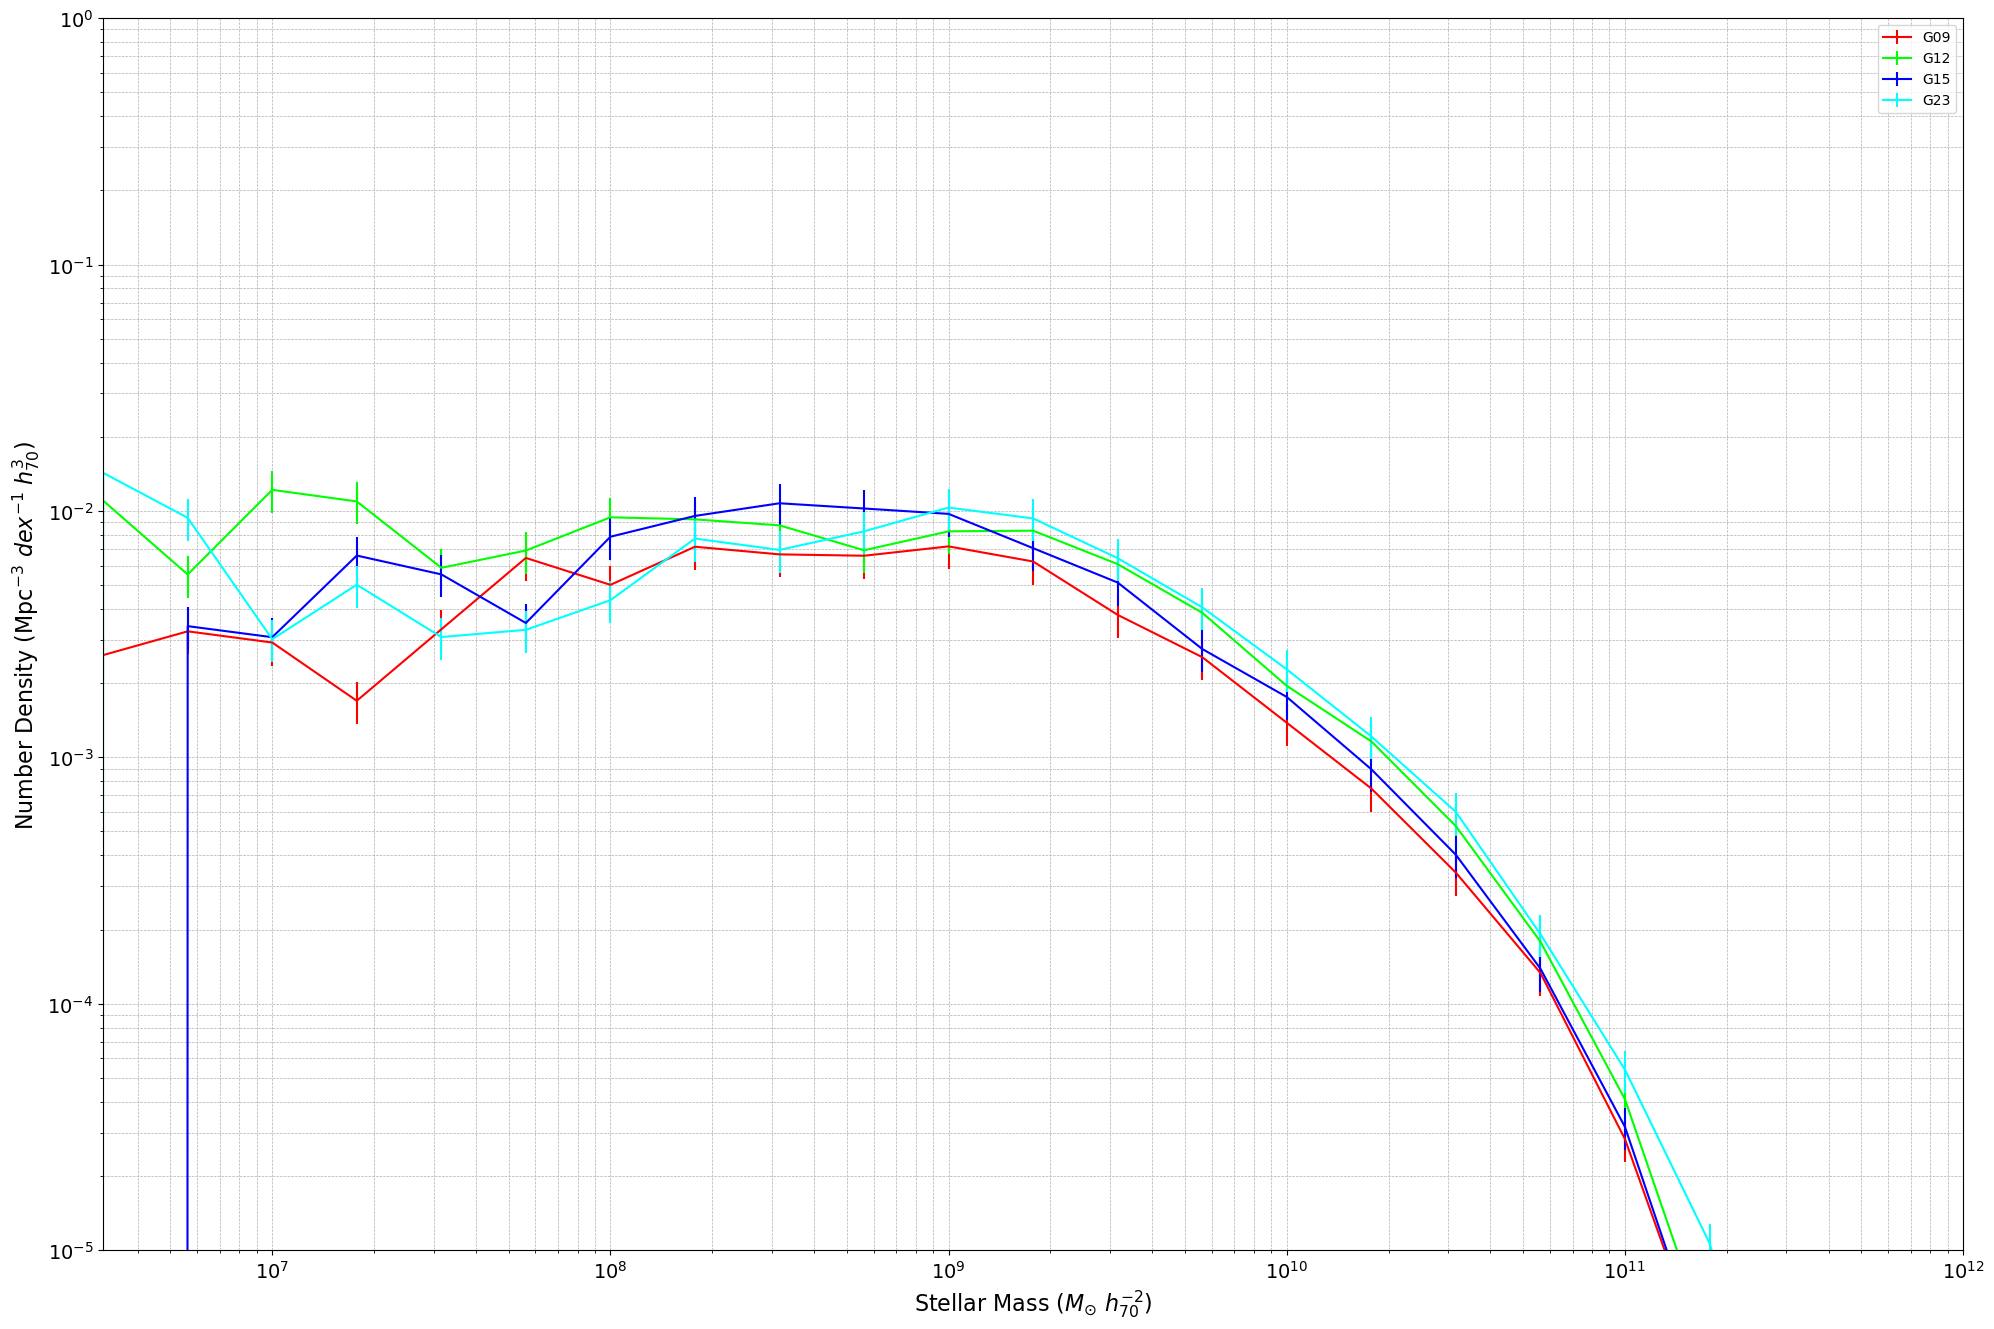

In [7]:
region_colors = {'G09': 'red', 'G12': 'lime', 'G15': 'blue', 'G23': 'cyan'}
fig, ax = plt.subplots(figsize=(24, 16))
for region_name in REGIONS_OF_SKY.keys():
    mass_hist, error = get_weighted_mass_histogram(input_mass_completeness_dataframe=full_mass_completeness_dataframe, region_name=region_name)

    plt.errorbar(
        MASS_BINS[:-1],
        mass_hist,
        yerr=error,
        label=region_name,
        color=region_colors.get(region_name),
    )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass ($M_{\odot} \ h_{70}^{-2}$)', fontsize=16)
plt.ylabel('Number Density ($\mathrm{Mpc}^{-3} \ dex^{-1} \ h_{70}^{3}$)', fontsize=16)
plt.xlim((10**6.5, 10**12))
plt.ylim((1e-5, 1e0))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
